<a href="https://colab.research.google.com/github/akhilspillai003/Pytorch/blob/main/CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [129]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid

import numpy as np
import pandas as pd
import sklearn.metrics as metrics
import matplotlib.pyplot as plt
%matplotlib inline

In [130]:
#change MINST image files to tensor of 4 Dimentions (# of images, height, width, colour label)
transform = transforms.ToTensor()

In [131]:
#Train Data
train_data = datasets.MNIST(root='/cnn_data', train=True, download=True, transform=transform)

In [132]:
#Test Data
test_data = datasets.MNIST(root='/cnn_data', train=False, download=True, transform=transform)

In [133]:
train_data

Dataset MNIST
    Number of datapoints: 60000
    Root location: /cnn_data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [134]:
 test_data

Dataset MNIST
    Number of datapoints: 10000
    Root location: /cnn_data
    Split: Test
    StandardTransform
Transform: ToTensor()

In [135]:
#Create a small batch size of images... lats say 10
train_loader = DataLoader(train_data, batch_size=10, shuffle=True)
test_loader = DataLoader(test_data, batch_size=10, shuffle=True)

In [136]:
#Define our CNN model
conv1 = nn.Conv2d(1, 6, 3, 1)
conv2 = nn.Conv2d(6, 16, 3, 1)

In [137]:
#Grab one Mnist record image
for i, (X_Train, y_train) in enumerate(train_data):
    break

In [138]:
X_Train.shape


torch.Size([1, 28, 28])

In [139]:
x = X_Train.view(1, 1, 28, 28)

In [140]:
#Performing our first convolution
x = F.relu(conv1(x)) #rectified linear unit for our activation function


In [141]:
# 1 singel image,  6 is the filter we asked for, 26x26
x.shape

torch.Size([1, 6, 26, 26])

In [142]:
#PAss thru the poolong layer
x = F.max_pool2d(x,2,2) #kernel of 2 and stride of 2

In [143]:
x.shape

torch.Size([1, 6, 13, 13])

In [144]:
#DO the second convolution layer
x = F.relu(conv2(x))

In [145]:
x.shape # we didnt set padding so we loose 2 pixels around the outside of the image

torch.Size([1, 16, 11, 11])

In [146]:
#pooling layer
x = F.max_pool2d(x,2,2)

In [147]:
x.shape


torch.Size([1, 16, 5, 5])

In [148]:
#Model Class
class ConvulutionalNetwork(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(1, 6, 3, 1)
    self.conv2 = nn.Conv2d(6, 16, 3, 1)

    #Fully connected layer
    self.fc1 = nn.Linear(5*5*16, 120)
    self.fc2 = nn.Linear(120, 84)
    self.fc3 = nn.Linear(84, 10)

  def forward(self, X):
    X = F.relu(self.conv1(X))
    X = F.max_pool2d(X, 2, 2)
    #Second Pass
    X = F.relu(self.conv2(X))
    X = F.max_pool2d(X, 2, 2)

    #re-view to flattern it out
    X = X.view(-1, 16*5*5) #negative one so we can change the batch size

    #FUlly connected layers
    X = F.relu(self.fc1(X))
    X = F.relu(self.fc2(X))
    X = self.fc3(X)
    return F.log_softmax(X, dim=1)

In [149]:
#Create an instance of the model
torch.manual_seed(41)
model = ConvulutionalNetwork()
model

ConvulutionalNetwork(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [150]:
#Loss FUnction Optimiser
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) #smaller the learning rate the longer it is gonna take

In [151]:
import time
start_time = time.time()

#Create variebles to track things
epochs = 5
train_losses = []
test_losses = []
train_correct = []
test_correct = []

#for loop Epoch
for i in range(epochs):
  trn_corr = 0
  tst_corr = 0

  #train
  for b, (X_train, y_train) in enumerate(train_loader):
    b+=1 #start our batches at 1
    y_pred = model(X_train) #get predicted values from training set - Not flattened
    loss = criterion(y_pred, y_train) #calculate loss

    predicted = torch.max(y_pred.data, 1)[1] #add up the numbe rof correct predictions, Index of the first point
    batch_corr = (predicted == y_train).sum() #how many we got correct from this batch.
    trn_corr += batch_corr #keep track as we go along in training

    #update our parameters
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    #print our parameters
    if b%600 == 0:
      print(f'Epoch: {i} Batch: {b} Loss: {loss.item()}')

  train_losses.append(loss)
  train_correct.append(trn_corr)

  #test
  with torch.no_grad(): #No gradient so we dont update out weights and biases with test
    for b, (X_test, y_test) in enumerate(test_loader):
      y_val = model(X_test)
      predicted = torch.max(y_val.data, 1)[1] #Adding up correct Predictions
      tst_corr += (predicted == y_test).sum() #T=1 F=0 and sum away

  loss = criterion(y_val, y_test)
  test_losses.append(loss)
  test_correct.append(tst_corr)

current_time = time.time()
total = current_time - start_time
print(f'Training took: {total/60} minutes!')

Epoch: 0 Batch: 600 Loss: 0.1623610556125641
Epoch: 0 Batch: 1200 Loss: 0.1502392590045929
Epoch: 0 Batch: 1800 Loss: 0.4744560718536377
Epoch: 0 Batch: 2400 Loss: 0.14238706231117249
Epoch: 0 Batch: 3000 Loss: 0.007758188061416149
Epoch: 0 Batch: 3600 Loss: 0.3836284875869751
Epoch: 0 Batch: 4200 Loss: 0.0038223876617848873
Epoch: 0 Batch: 4800 Loss: 0.0021286322735249996
Epoch: 0 Batch: 5400 Loss: 0.0569545142352581
Epoch: 0 Batch: 6000 Loss: 0.00038789428072050214
Epoch: 1 Batch: 600 Loss: 0.02950388565659523
Epoch: 1 Batch: 1200 Loss: 0.01223783753812313
Epoch: 1 Batch: 1800 Loss: 0.0017079260433092713
Epoch: 1 Batch: 2400 Loss: 0.004794587381184101
Epoch: 1 Batch: 3000 Loss: 0.00012589071411639452
Epoch: 1 Batch: 3600 Loss: 0.006774441804736853
Epoch: 1 Batch: 4200 Loss: 0.00024002441205084324
Epoch: 1 Batch: 4800 Loss: 0.011869433335959911
Epoch: 1 Batch: 5400 Loss: 0.0003403539885766804
Epoch: 1 Batch: 6000 Loss: 0.0003896451380569488
Epoch: 2 Batch: 600 Loss: 0.2102451026439666

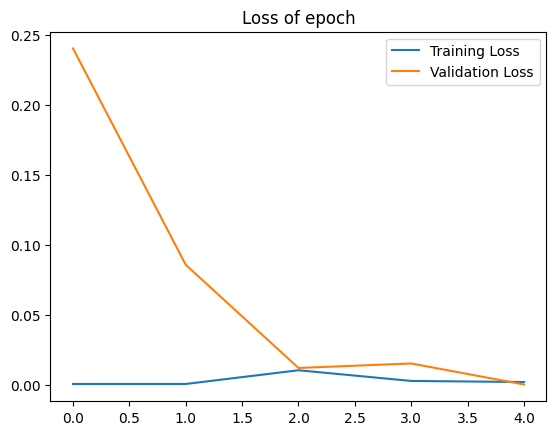

In [152]:
#graph the loss at epoch
train_losses = [tl.item() for tl in train_losses]
plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Validation Loss')
plt.title('Loss of epoch')
plt.legend()

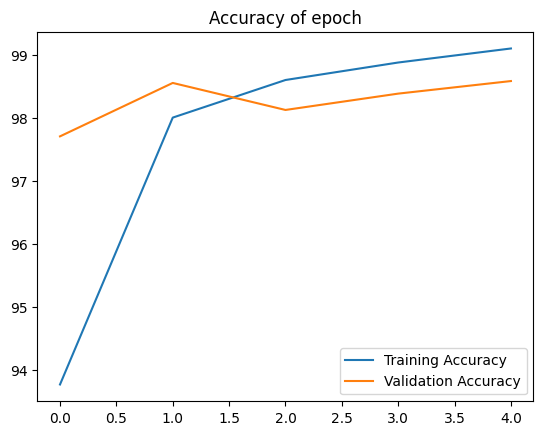

In [153]:
#Graph the accuracy at the end of each epoch
plt.plot([t/600 for t in train_correct], label='Training Accuracy')
plt.plot([t/100 for t in test_correct], label='Validation Accuracy')
plt.title('Accuracy of epoch')
plt.legend()

In [154]:
test_load_everything = DataLoader(test_data, batch_size = 1000, shuffle=False)

In [155]:
with torch.no_grad():
  correct = 0
  for X_test, y_test in test_load_everything:
    y_val = model(X_test)
    predicted = torch.max(y_val, 1)[1]
    correct += (predicted == y_test).sum()

In [157]:
# Did for correct
correct.item()/len(test_data)*100

98.59

In [161]:
#Gram an image
test_data[4143] #Tensor with an image in it... at end it shows the label

(tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 

In [162]:
#Grab just the data
test_data[4143][0]

tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,

In [163]:
#Reshape it
test_data[4143][0].view(28, 28)

tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000

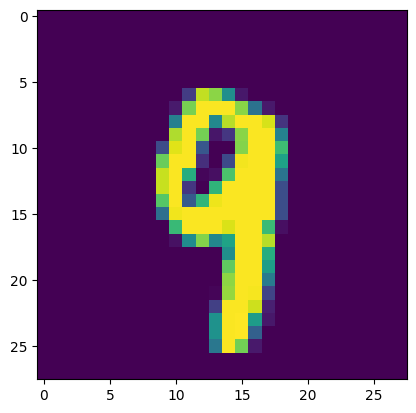

In [164]:
#show the image
plt.imshow(test_data[4143][0].view(28, 28))

In [166]:
#pass the image thru the model
model.eval()
with torch.no_grad():
  new_prediction = model(test_data[4143][0].view(1, 1, 28, 28)) # batch size 1, colour channel 1, 28x28

In [167]:
new_prediction

tensor([[-1.9783e+01, -2.0513e+01, -2.0931e+01, -1.3588e+01, -9.8797e+00,
         -1.4948e+01, -3.3749e+01, -9.2057e+00, -1.4788e+01, -1.5365e-04]])

In [168]:
new_prediction.argmax()

tensor(9)